# Damiano Ficara


## Packages

In [81]:
import networkx as nx # For graphs
import pickle # For data parsing
from networkx.algorithms.approximation import greedy_tsp # For approx TSP
import numpy as np

import torch
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn as nn
from torch.nn import Transformer
from torch import Tensor

import warnings
from timeit import default_timer as timer
import math

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


## Helper functions

In [82]:

def tour_length(G, tour):
    """
    Compute the length of a tour. A tour is a list having elments 0 and -1 equal
    """
    n = len(tour) - 1
    assert tour[0] == tour[-1], "Not valid tour"
    estimated = 0
    for i in range(n):
        estimated += G[tour[i]][tour[i + 1]]['weight']
    return estimated

def greedy_algorithm(G):
    """
    Run the value of the greedy approximation algorithm on graph G
    """
    return tour_length(G, greedy_tsp(G, weight='weight'))

def random_tour(G, seed = 42):
    """
    Return the value of a random tour
    """
    np.random.seed(seed)
    n = G.number_of_nodes()
    tour = [0]
    for i in range(1, n):
        next_node = np.random.choice([j for j in range(n) if j not in tour])
        tour.append(next_node)
    tour.append(0)
    return tour_length(G, tour)
    

def transformer_tsp(G, model, DEVICE='cpu'):
    """
    Evaluate your (trained) model on G.
    """
    # Set the model in evaluation mode
    model.eval()

    # Number of nodes
    n = G.number_of_nodes()
    #print(f"Number of nodes in the graph (n): {n}")

    # Get node coordinates
    attr = nx.get_node_attributes(G, 'pos')
    x = torch.tensor([attr[i] for i in range(n)], dtype=torch.float32)  # Convert directly to tensor
    #print(f"Node coordinates shape (x): {x.shape}")

    # Initialize the tour with node 0
    tour = [0]
    y = torch.tensor(tour, dtype=torch.long)
    #print(f"Initial tour shape (y): {y.shape}")

    # Move tensors to the correct device
    x = x.to(DEVICE).unsqueeze(0)  # Add batch dimension
    y = y.to(DEVICE).unsqueeze(0)  # Add batch dimension
    #print(f"Node coordinates shape after unsqueeze (x): {x.shape}")
    #print(f"Initial tour shape after unsqueeze (y): {y.shape}")

    # Generate initial masks
    src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(x, y, DEVICE)
    #print(f"Initial target mask shape (tgt_mask): {tgt_mask.shape}")
    #print(f"Initial target padding mask shape (tgt_padding_mask): {tgt_padding_mask.shape}")

    # Generate the tour using the model
    out = model(x, y, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
    #print(f"Model output shape (out): {out.shape}")

    while len(tour) < n:
        _, idx = torch.topk(out, n, dim=2)
        #print(f"Top-k indices shape (idx): {idx.shape}")
        for i in range(n):
            if idx[0, 0, i] not in tour:
                tour.append(idx[0, -1, i])
                break
        y = torch.tensor(tour, dtype=torch.long)
        y = y.to(DEVICE).unsqueeze(0)
        #print(f"Updated tour shape (y): {y.shape}")

        # Update the target mask and padding mask for the new sequence length
        tgt_mask = generate_square_subsequent_mask(y.shape[1]).to(DEVICE)
        tgt_padding_mask = torch.zeros((y.shape[0], y.shape[1]), device=DEVICE).type(torch.bool)
        #print(f"Updated target mask shape (tgt_mask): {tgt_mask.shape}")
        #print(f"Updated target padding mask shape (tgt_padding_mask): {tgt_padding_mask.shape}")

        out = model(x, y, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)
        #print(f"Updated model output shape (out): {out.shape}")

    # Ensure the tour starts and ends at node 0
    tour = [int(i) for i in tour] + [0]
    #print(f"Final tour: {tour}")
    return tour_length(G, tour)

def gap(G, model = None, model_GA = None, random_seed = 42, device = 'cpu'):
    """
    Compute the gap between the optimal solution on graph G and all the analyzed methods
    """
        
    # Optimal value (hard-coded in the graph)
    TSP = sum([G[i][j]['weight']*G[i][j]['tour'] for (i, j) in G.edges()]) # Optimal

    # Gaps dictionary
    gaps = {'greedy' : 0, 'random' : 0, 'transformer_tsp': 0, 'transformer_tsp_acc_grad': 0}
    gaps['greedy'] = 100* (greedy_algorithm(G) -  TSP) / TSP
    gaps['random'] = 100 * (random_tour(G, random_seed) - TSP) / TSP
    if model is not None:
        gaps['transformer_tsp'] = 100 * (transformer_tsp(G, model, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp'] = float('inf')
        
    if model_GA is not None:
        gaps['transformer_tsp_acc_grad'] = 100 * (transformer_tsp(G, model_GA, DEVICE=device) - TSP) / TSP
    else:
        gaps['transformer_tsp_acc_grad'] = float('inf')
    return gaps    
    

## Dataset & Dataloader

In [83]:
# Load the dummy dataset
with open('/kaggle/input/tsp-dataset/dummy_20_DLL_ass4.pkl', 'rb') as file:
   dummy = pickle.load(file)

# Print type of overall dataset and a single item
print(f"Type of dummy dataset is: {type(dummy)}")
single_item = dummy[0]
print(f"\nType of a single item is: {type(single_item)}")

# Print types of elements in the tuple
print(f"\nTypes of elements in the tuple:")
print(f"First element type: {type(single_item[0])}") # Graph
print(f"Second element type: {type(single_item[1])}") # List

print("\Single Item structure:")
print(single_item)

Type of dummy dataset is: <class 'list'>

Type of a single item is: <class 'tuple'>

Types of elements in the tuple:
First element type: <class 'networkx.classes.graph.Graph'>
Second element type: <class 'list'>
\Single Item structure:
(<networkx.classes.graph.Graph object at 0x7add78788c40>, [0, 3, 14, 2, 9, 6, 19, 13, 12, 16, 7, 18, 8, 17, 5, 11, 10, 15, 1, 4, 0])


In [84]:
# Describe the edge attributes tour and weight, as well as the node attribute pos.


graph = single_item[0] 
tour = single_item[1]  # in this case tour as a list

# Describe node attribute: pos
node_positions = nx.get_node_attributes(graph, 'pos')
print("\nNode positions (pos):")
for node, pos in node_positions.items():
    print(f"Node {node}: Position {pos}")

# Describe edge attribute: weight
print("\nEdge weights:")
for u, v in graph.edges():
    weight = graph[u][v].get('weight', None) 
    print(f"Edge ({u}, {v}): Weight {weight}")

# Describe edge attribute: tour
print("\nTour:")
print(f"Tour as per solution: {tour}")






Node positions (pos):
Node 0: Position (0.6049077053425551, 0.5748590937018008)
Node 1: Position (0.38474987528197846, 0.9428085200806016)
Node 2: Position (0.6102491981278754, 0.3707527129445174)
Node 3: Position (0.5497610140601452, 0.514788385568776)
Node 4: Position (0.5941533303116413, 0.6544475361385552)
Node 5: Position (0.06187381797691738, 0.433195284467101)
Node 6: Position (0.7475717305758963, 0.3950876312718402)
Node 7: Position (0.6548530739834322, 0.06254140180263457)
Node 8: Position (0.2210796367473482, 0.2142238067774731)
Node 9: Position (0.6696714621150585, 0.4364218673039507)
Node 10: Position (0.3206284506117195, 0.7885615893113229)
Node 11: Position (0.37760295594024584, 0.4963855605324464)
Node 12: Position (0.8300002368321365, 0.3489482457969727)
Node 13: Position (0.9983722301898076, 0.2725163812162502)
Node 14: Position (0.5306200040273271, 0.4146737532387711)
Node 15: Position (0.2540580284004623, 0.8878378722372976)
Node 16: Position (0.7024553839343133, 0.

In [85]:
# Dataset Class
import torch
from torch.utils.data import Dataset

class TSPDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data (list): A list where each element is a tuple (graph, tour).
                         - graph: Graph object containing node positions as 'pos' attribute.
                         - tour: List of node indices representing the tour.
        """
        self.data = data

    def __len__(self):
        """
        Return the number of samples in the dataset.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Args:
            idx (int): Index of the data sample to retrieve.
        
        Returns:
            X (torch.Tensor): A tensor of shape (20, 2) representing node coordinates.
            y (torch.Tensor): A tensor of shape (n+1,) representing the tour starting and ending at 0.
        """
        graph, tour = self.data[idx]

        # Extract node positions from the graph
        pos = nx.get_node_attributes(graph, 'pos')  # Assumes graph stores positions in 'pos'
        X = torch.tensor([pos[node] for node in sorted(pos.keys())], dtype=torch.float32)

        # Ensure the tour starts and ends at node 0
        if tour[0] != 0:
            raise ValueError("Tour must start at node 0.")
        if tour[-1] != 0:
            tour = tour + [0]  # Append 0 to ensure the tour ends at the start node

        y = torch.tensor(tour, dtype=torch.long)

        return X, y


In [86]:
# Create Dataset objects for training, validation, and testing, along with their respective Dataloader

# tspdataset = TSPDataset(dummy)
# train_dataset, validation_dataset, test_dataset = random_split(tspdataset, [0.8, 0.1, 0.1])

# batch_size = 32

# trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# valloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
# testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)





In [87]:
# Funzione per caricare i file pickle
def load_pickle(file_path):
    with open(file_path, 'rb') as file:
        return pickle.load(file)

# Caricamento dei dati
data_paths = {
    'train': '/kaggle/input/tsp-dataset/train_20_DLL_ass4.pkl',
    'valid': '/kaggle/input/tsp-dataset/valid_20_DLL_ass4.pkl',
    'test': '/kaggle/input/tsp-dataset/test_20_DLL_ass4.pkl'
}

data = {key: load_pickle(path) for key, path in data_paths.items()}

# Creazione dei dataset
batch_size = 32
datasets = {key: TSPDataset(data[key]) for key in data_paths.keys()}

# Creazione dei DataLoader
dataloaders = {key: DataLoader(datasets[key], batch_size=batch_size) for key in datasets.keys()}

# Accesso ai DataLoader
trainloader = dataloaders['train']
valloader = dataloaders['valid']
testloader = dataloaders['test']

In [88]:
# Verifica il contenuto del file pickle
print("Sample from pickle file:")
first_item = next(iter(data['test']))
print(type(first_item))
print(first_item)

# Verifica l'output del dataset
test_dataset = datasets['test']
first_sample = test_dataset[0]
print("\nFirst sample from dataset:")
print(type(first_sample))
print(first_sample)

Sample from pickle file:
<class 'tuple'>
(<networkx.classes.graph.Graph object at 0x7add78e52a70>, [0, 4, 5, 9, 18, 15, 11, 10, 2, 8, 12, 3, 7, 6, 16, 1, 13, 19, 14, 17, 0])

First sample from dataset:
<class 'tuple'>
(tensor([[0.9885, 0.3492],
        [0.1478, 0.0803],
        [0.6854, 0.9078],
        [0.4484, 0.4158],
        [0.7753, 0.3009],
        [0.8387, 0.5283],
        [0.1509, 0.3257],
        [0.0159, 0.5711],
        [0.4317, 0.9926],
        [0.9416, 0.7014],
        [0.7045, 0.9269],
        [0.8466, 0.9743],
        [0.5252, 0.6898],
        [0.2320, 0.1911],
        [0.5875, 0.0876],
        [0.7872, 0.7704],
        [0.0340, 0.0321],
        [0.9774, 0.0267],
        [0.8589, 0.7154],
        [0.4387, 0.0959]]), tensor([ 0,  4,  5,  9, 18, 15, 11, 10,  2,  8, 12,  3,  7,  6, 16,  1, 13, 19,
        14, 17,  0]))


## Model

In [89]:
import torch
import torch.nn as nn
from torch import Tensor
import math

class TSPTransformer(nn.Module):
    def __init__(self, n, num_encoder, num_decoder, de, dd, n_head, dropout, dim_feedforward):
        super().__init__()
        # Encoder
        self.linear1 = nn.Linear(2, de)  # Linear 2 × d_e
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=de,
            nhead=n_head,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Aggiungi normalizzazione
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder)
        self.linear2 = nn.Linear(de, dd)  # Linear d_e × d_d
        
        # Decoder
        self.embedding = nn.Embedding(n, dd)  # Embedding n × d_d
        self.posEncoding = PositionalEncoding(dd, dropout)  # Positional Encoding
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=dd,
            nhead=n_head,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=True  # Aggiungi normalizzazione
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder)
        self.ffnn = nn.Linear(dd, n)  # Feed Forward from d_d to n
        
        # Inizializzazione dei pesi
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(self, src, trg, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask):
        # Encoding
        x = self.linear1(src)
        x = self.encoder(x, mask=src_mask, src_key_padding_mask=src_padding_mask)
        memory = self.linear2(x)
        
        # Decoding
        x = self.embedding(trg)
        x = self.posEncoding(x)
        x = self.decoder(x, memory, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_padding_mask)
        output = self.ffnn(x)
        
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, emb_size: int, dropout: float, maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        den = torch.exp(- torch.arange(0, emb_size, 2) * math.log(10000) / emb_size)
        
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)
    
    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

In [90]:
def generate_square_subsequent_mask(sequence_length: int) -> Tensor:
    mask = (torch.triu(torch.ones((sequence_length, sequence_length), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt, DEVICE):
    src_seq_len = src.shape[1]
    tgt_seq_len = tgt.shape[1]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len), device=DEVICE).type(torch.bool)

    src_padding_mask = torch.zeros((src.shape[0], src_seq_len), device=DEVICE).bool() # Corrected
    tgt_padding_mask = torch.zeros((tgt.shape[0], tgt_seq_len), device=DEVICE).bool() # Corrected

    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

In [91]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [92]:

n = 20  # Numero di nodi
n_enc = 4  # Riduci il numero di layer dell'encoder
n_dec = 4  # Riduci il numero di layer del decoder
de = 128 # Riduci la dimensione degli embedding
dd = 128
N_HEAD = 4  # Riduci il numero di teste di attenzione
DROPOUT = 0.3  # Aumenta il tasso di dropout
dim_feedforward = 512  # Riduci la dimensione del feedforward

model = TSPTransformer(n, n_enc, n_dec, de, dd, N_HEAD, DROPOUT, dim_feedforward).to(DEVICE)

## Training

In [93]:
import math

def evaluate(model, valloader, loss_fn, DEVICE):
    # Set the model to evaluation mode
    model.eval()
    losses = 0

    # Iterate over batches in the validation loader
    for src, tgt in valloader:
        # Move data to the correct device (CPU/GPU)
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Target sequence (tour)

        # Prepare input for the decoder (exclude the last token)
        tgt_input = tgt[:, :-1]

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass: get model predictions
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Prepare target output (exclude the first token)
        tgt_out = tgt[:, 1:]

        # Compute the loss
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
    # Return the average loss 
    return losses / len(valloader)

In [94]:
def train_epoch(model, optimizer, trainloader, loss_fn, DEVICE):
    # Set the model to training mode
    model.train()
    losses = 0

    # Iterate over batches in the trainloader
    for src, tgt in trainloader:
        # Move data to the correct device (CPU/GPU)
        src = src.to(DEVICE)  # Node coordinates (input to the encoder)
        tgt = tgt.to(DEVICE)  # Target sequence (tour)

        # Prepare input for the decoder (exclude the last token)
        tgt_input = tgt[:, :-1]

        # Clear accumulated gradients
        optimizer.zero_grad()

        # Generate masks for attention
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)

        # Forward pass: get model predictions
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Prepare target output (exclude the first token)
        tgt_out = tgt[:, 1:]

        # Compute the loss
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))

        # Backward pass: compute gradients
        loss.backward()

        # Update model weights
        optimizer.step()

        # Accumulate the loss
        losses += loss.item()

    # Return the average loss for the epoch
    return losses / len(trainloader)

### Training WITHOUT gradient accumulation

In [95]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn import CrossEntropyLoss
from time import time
from torch.utils.data import DataLoader

# Hyperparameters
LEARNING_RATE = 0.0002
BETAS = (0.9, 0.98)
EPSILON = 1e-9
WEIGHT_DECAY = 0.01
NUM_EPOCHS = 15
PRINT_EVERY = 3
EARLY_STOPPING_PATIENCE = 5
COSINE_T0 = 5
COSINE_T_MULT = 2
COSINE_ETA_MIN = 1e-6

# Initialize the optimizer, scheduler, and loss function
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPSILON, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=COSINE_T0, T_mult=COSINE_T_MULT, eta_min=COSINE_ETA_MIN)
loss_fn = CrossEntropyLoss()

# # Training variables
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
best_epoch = 0
no_improvement_counter = 0  # Counter for early stopping

# Start the training timer
training_start_time = time()

# Training loop
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time()
    
    # Train for one epoch
    epoch_train_loss = train_epoch(model, optimizer, trainloader, loss_fn, DEVICE)
    train_loss_history.append(epoch_train_loss)
    
    # Evaluate on the validation set
    epoch_val_loss = evaluate(model, valloader, loss_fn, DEVICE)
    val_loss_history.append(epoch_val_loss)
    
    # Update the learning rate
    scheduler.step()
    
    # Check if the current model is the best so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        no_improvement_counter = 0  # Reset the early stopping counter
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
        }, 'best_model_noacc.pt')
    else:
        no_improvement_counter += 1  # Increment the counter if no improvement
    
    # Print training metrics every `PRINT_EVERY` epochs
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch: {epoch}")
        print(f"   Training Loss: {epoch_train_loss:.3f}, Validation Loss: {epoch_val_loss:.3f}")
        print(f"   Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"   Epoch Time: {time() - epoch_start_time:.3f} seconds")
    
    # Early stopping if no improvement for `EARLY_STOPPING_PATIENCE` epochs
    if no_improvement_counter >= EARLY_STOPPING_PATIENCE:
        print(f'Early stopping at epoch {epoch} after {EARLY_STOPPING_PATIENCE} epochs without improvement.')
        break
    
    # Stop training if the total training time exceeds 10 minutes (600 seconds)
    if time() - training_start_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

# Calculate total training time
total_training_time = time() - training_start_time

# Print training summary
print(f'Total Training Time: {total_training_time / 60:.2f} minutes')
print(f"The best model was obtained at epoch {best_epoch} with:")
print(f"   Training Loss: {train_loss_history[best_epoch - 1]:.3f}")
print(f"   Validation Loss: {best_val_loss:.3f}")

Epoch: 3
   Training Loss: 2.760, Validation Loss: 2.492
   Learning Rate: 0.000070
   Epoch Time: 43.748 seconds
Epoch: 6
   Training Loss: 2.437, Validation Loss: 2.083
   Learning Rate: 0.000195
   Epoch Time: 43.375 seconds
Epoch: 9
   Training Loss: 2.105, Validation Loss: 1.986
   Learning Rate: 0.000131
   Epoch Time: 44.149 seconds
Epoch: 12
   Training Loss: 2.050, Validation Loss: 1.976
   Learning Rate: 0.000042
   Epoch Time: 43.734 seconds
Reached ten minutes of training without overfitting at epoch 14
Total Training Time: 10.22 minutes
The best model was obtained at epoch 14 with:
   Training Loss: 2.039
   Validation Loss: 1.973


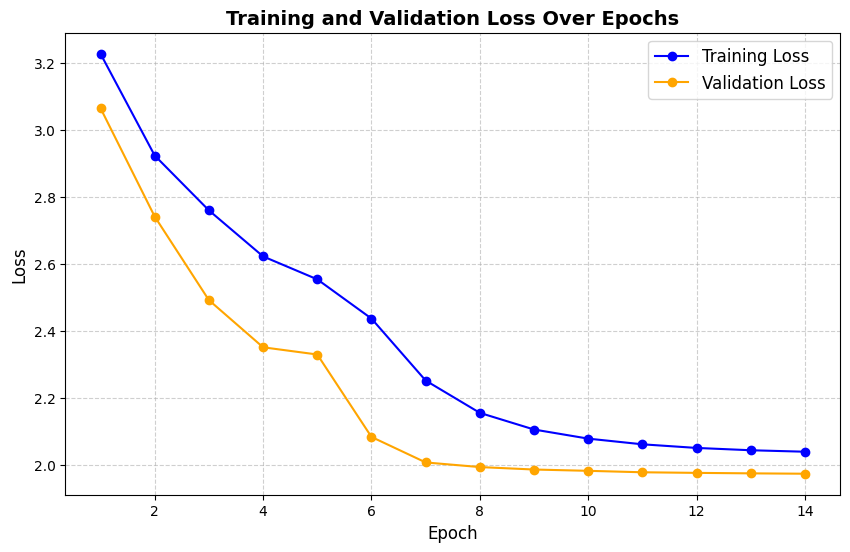

    Epoch  Training Loss  Validation Loss
0       1       3.228375         3.065770
1       2       2.924095         2.741764
2       3       2.760245         2.491962
3       4       2.622612         2.351010
4       5       2.554080         2.329441
5       6       2.436796         2.083096
6       7       2.251585         2.006886
7       8       2.154979         1.993039
8       9       2.105240         1.985705
9      10       2.078019         1.981818
10     11       2.061051         1.977494
11     12       2.050230         1.975698
12     13       2.043312         1.974262
13     14       2.038927         1.973167


In [96]:


# Creazione del grafico
plt.figure(figsize=(10, 6))  # Imposta la dimensione della figura
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', marker='o', linestyle='-', color='orange')

# Aggiunta di etichette e titolo
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Epochs', fontsize=14, fontweight='bold')

# Aggiunta della griglia per migliorare la leggibilità
plt.grid(True, linestyle='--', alpha=0.6)

# Aggiunta della legenda
plt.legend(fontsize=12)
plt.savefig("plots1.png")
# Mostra il grafico
plt.show()

# Creazione di un DataFrame per le perdite
loss_table = pd.DataFrame({
    'Epoch': range(1, len(train_loss_history) + 1),  # Numero di epoche
    'Training Loss': train_loss_history,             # Perdite di training
    'Validation Loss': val_loss_history              # Perdite di validazione
})

# Stampa della tabella
print(loss_table)

### Training WITH gradient accumulation

In [97]:
def train_epoch_with_accumulation(model, optimizer, trainloader, loss_fn, DEVICE, accumulation_steps):
    model.train()
    total_loss = 0.0
    optimizer.zero_grad()  # Clear gradients at the start of the epoch

    for step, (src, tgt) in enumerate(trainloader):
        src = src.to(DEVICE)  # Move data to the correct device (CPU/GPU)
        tgt = tgt.to(DEVICE)

        # Prepare input and output for the decoder
        tgt_input = tgt[:, :-1]
        tgt_out = tgt[:, 1:]

        # Forward pass
        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input, DEVICE)
        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        # Compute the loss
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps  # Normalize loss for gradient accumulation
        loss.backward()  # Accumulate gradients

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 

        # Perform optimizer step and zero gradients after `accumulation_steps`
        if (step + 1) % accumulation_steps == 0:
            optimizer.step()  # Update weights
            optimizer.zero_grad()  # Clear gradients for the next accumulation

        # Accumulate the loss
        total_loss += loss.item() * accumulation_steps  # Scale back the loss

    # Return the average loss for the epoch
    return total_loss / len(trainloader)

In [98]:
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.nn import CrossEntropyLoss
from time import time
from torch.utils.data import DataLoader

#Hyperparameters
n = 20  # Numero di nodi
n_enc = 4  # Riduci il numero di layer dell'encoder
n_dec = 4  # Riduci il numero di layer del decoder
de = 128 # Riduci la dimensione degli embedding
dd = 128
N_HEAD = 4  # Riduci il numero di teste di attenzione
DROPOUT = 0.3  # Aumenta il tasso di dropout
dim_feedforward = 512  # Riduci la dimensione del feedforward

# Hyperparameters
LEARNING_RATE = 0.001  # Riduci il learning rate
WEIGHT_DECAY = 0.01  # Aumenta il weight decay
GRADIENT_ACCUMULATION_STEPS = 4  # Riduci il numero di passi di accumulo

#Inizializzazione del modello
model_change = TSPTransformer(n,n_enc,n_dec,de,dd,N_HEAD,DROPOUT,dim_feedforward).to(DEVICE)
BETAS = (0.9, 0.98)
EPSILON = 1e-9
NUM_EPOCHS = 30
PRINT_EVERY = 3
EARLY_STOPPING_PATIENCE = 5
COSINE_T0 = 5
COSINE_T_MULT = 2
COSINE_ETA_MIN = 1e-6

# Initialize the optimizer, scheduler, and loss function
optimizer = AdamW(model_change.parameters(), lr=LEARNING_RATE, betas=BETAS, eps=EPSILON, weight_decay=WEIGHT_DECAY)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=COSINE_T0, T_mult=COSINE_T_MULT, eta_min=COSINE_ETA_MIN)
loss_fn = CrossEntropyLoss()

# Training variables
train_loss_history = []
val_loss_history = []
best_val_loss = float('inf')
best_epoch = 0
no_improvement_counter = 0  # Counter for early stopping

# Start the training timer
training_start_time = time()
# Training loop with gradient accumulation
for epoch in range(1, NUM_EPOCHS + 1):
    epoch_start_time = time()
    
    # Train for one epoch with gradient accumulation
    epoch_train_loss = train_epoch_with_accumulation(model_change, optimizer, trainloader, loss_fn, DEVICE, GRADIENT_ACCUMULATION_STEPS)
    train_loss_history.append(epoch_train_loss)
    
    # Evaluate on the validation set
    epoch_val_loss = evaluate(model_change, valloader, loss_fn, DEVICE)
    val_loss_history.append(epoch_val_loss)
    
    # Update the learning rate
    scheduler.step()
    
    # Check if the current model is the best so far
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_epoch = epoch
        no_improvement_counter = 0  # Reset the early stopping counter
        
        # Save the best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model_change.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': epoch_train_loss,
            'val_loss': epoch_val_loss,
        }, 'best_model_withacc.pt')
    else:
        no_improvement_counter += 1  # Increment the counter if no improvement
    
    # Print training metrics every `PRINT_EVERY` epochs
    if epoch % PRINT_EVERY == 0:
        print(f"Epoch: {epoch}")
        print(f"   Training Loss: {epoch_train_loss:.3f}, Validation Loss: {epoch_val_loss:.3f}")
        print(f"   Learning Rate: {scheduler.get_last_lr()[0]:.6f}")
        print(f"   Epoch Time: {time() - epoch_start_time:.3f} seconds")
    
    # Early stopping if no improvement for `EARLY_STOPPING_PATIENCE` epochs
    if no_improvement_counter >= EARLY_STOPPING_PATIENCE:
        print(f'Early stopping at epoch {epoch} after {EARLY_STOPPING_PATIENCE} epochs without improvement.')
        break
    
    # Stop training if the total training time exceeds 10 minutes (600 seconds)
    if time() - training_start_time >= 600:
        print(f'Reached ten minutes of training without overfitting at epoch {epoch}')
        break

# Calculate total training time
total_training_time = time() - training_start_time

# Print training summary
print(f'Total Training Time: {total_training_time / 60:.2f} minutes')
print(f"The best model was obtained at epoch {best_epoch} with:")
print(f"   Training Loss: {train_loss_history[best_epoch - 1]:.3f}")
print(f"   Validation Loss: {best_val_loss:.3f}")

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5193: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Epoch: 3
   Training Loss: 2.310, Validation Loss: 2.018
   Learning Rate: 0.000346
   Epoch Time: 43.764 seconds
Epoch: 6
   Training Loss: 2.104, Validation Loss: 1.987
   Learning Rate: 0.000976
   Epoch Time: 43.608 seconds
Epoch: 9
   Training Loss: 2.036, Validation Loss: 1.982
   Learning Rate: 0.000655
   Epoch Time: 44.425 seconds
Epoch: 12
   Training Loss: 2.011, Validation Loss: 1.975
   Learning Rate: 0.000207
   Epoch Time: 43.507 seconds
Reached ten minutes of training without overfitting at epoch 14
Total Training Time: 10.22 minutes
The best model was obtained at epoch 14 with:
   Training Loss: 2.001
   Validation Loss: 1.971


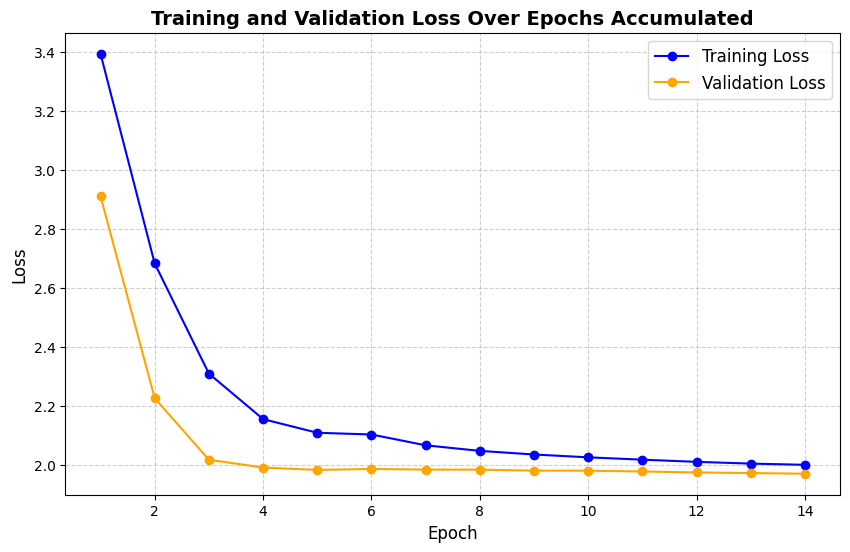

    Epoch  Training Loss  Validation Loss
0       1       3.392534         2.910284
1       2       2.682645         2.226584
2       3       2.309953         2.018441
3       4       2.155898         1.992035
4       5       2.109759         1.983991
5       6       2.103865         1.987143
6       7       2.067233         1.985059
7       8       2.048419         1.984830
8       9       2.036173         1.981528
9      10       2.026576         1.981425
10     11       2.018673         1.978691
11     12       2.011296         1.975447
12     13       2.005358         1.973313
13     14       2.001278         1.971130


In [99]:


# Creazione del grafico
plt.figure(figsize=(10, 6))  # Imposta la dimensione della figura
plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, label='Validation Loss', marker='o', linestyle='-', color='orange')

# Aggiunta di etichette e titolo
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training and Validation Loss Over Epochs Accumulated', fontsize=14, fontweight='bold')

# Aggiunta della griglia per migliorare la leggibilità
plt.grid(True, linestyle='--', alpha=0.6)

# Aggiunta della legenda
plt.legend(fontsize=12)
plt.savefig("plots2.jpg")
# Mostra il grafico
plt.show()

# Creazione di un DataFrame per le perdite
loss_table = pd.DataFrame({
    'Epoch': range(1, len(train_loss_history) + 1),  # Numero di epoche
    'Training Loss': train_loss_history,             # Perdite di training
    'Validation Loss': val_loss_history              # Perdite di validazione
})

# Stampa della tabella
print(loss_table)

## Testing

In [108]:

# Inizializzazione del modello standard con parametri passati direttamente
model_standard = TSPTransformer(
       n=20, num_encoder=6, num_decoder=6, de=256,dd=256, n_head=8, dropout=0.3, dim_feedforward=1024
).to(DEVICE)
# Caricamento del checkpoint per il modello standard
checkpoint_standard = torch.load('/kaggle/input/models/pytorch/default/1/best_model_noacc.pt', map_location=DEVICE)
model_standard.load_state_dict(checkpoint_standard['model_state_dict'])
model_standard.eval()

# Caricamento del checkpoint per il modello con gradient accumulation
checkpoint_accumulation = torch.load('/kaggle/input/models/pytorch/default/1/best_model_withacc.pt', map_location=DEVICE)
model_accumulation = TSPTransformer(
       n=20, num_encoder=4, num_decoder=4, de=128,dd=128, n_head=4, dropout=0.3, dim_feedforward=512
).to(DEVICE)
# Cari
model_accumulation.load_state_dict(checkpoint_accumulation['model_state_dict'])
model_accumulation.eval()


<ipython-input-108-4d1c6d65c953>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_standard = torch.load('/kaggle/input/models/pytorch/default/1/best_model_noacc.p

TSPTransformer(
  (linear1): Linear(in_features=2, out_features=128, bias=True)
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.3, inplace=False)
        (dropout2): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (linear2): Linear(in_features=128, out_features=128, bias=True)
  (embedding): Embedding(20, 128)
  (posEncoding): PositionalEncoding(
    (dropout): Dropout(p=0.3, inplace=False)
  )
  (decoder): TransformerDecod

In [109]:
# Prendi un batch dal testloader
batch = next(iter(testloader))

# Stampa il contenuto del batch
print("Tipo del batch:", type(batch))
print("Numero di elementi nel batch:", len(batch))

# Ispeziona ogni elemento del batch
for i, item in enumerate(batch):
    print(f"Elemento {i}:")
    print("Tipo:", type(item))
    print("Contenuto:", item)

Tipo del batch: <class 'list'>
Numero di elementi nel batch: 2
Elemento 0:
Tipo: <class 'torch.Tensor'>
Contenuto: tensor([[[0.9885, 0.3492],
         [0.1478, 0.0803],
         [0.6854, 0.9078],
         ...,
         [0.9774, 0.0267],
         [0.8589, 0.7154],
         [0.4387, 0.0959]],

        [[0.2531, 0.9016],
         [0.6064, 0.9712],
         [0.3547, 0.2373],
         ...,
         [0.6077, 0.5308],
         [0.1972, 0.1064],
         [0.4571, 0.9726]],

        [[0.2843, 0.4235],
         [0.1046, 0.9481],
         [0.9762, 0.1283],
         ...,
         [0.1027, 0.7761],
         [0.0418, 0.8183],
         [0.1599, 0.5197]],

        ...,

        [[0.7307, 0.3430],
         [0.9054, 0.7747],
         [0.4424, 0.7009],
         ...,
         [0.5018, 0.3610],
         [0.0518, 0.3813],
         [0.7186, 0.5195]],

        [[0.1404, 0.7987],
         [0.8916, 0.1851],
         [0.8945, 0.5161],
         ...,
         [0.1577, 0.0574],
         [0.8317, 0.9573],
         [

In [110]:
def tensor_to_graph(coords, tour):
 
    num_nodes = coords.shape[0]
    G = nx.Graph()
    
    # Add nodes with their coordinates
    for i in range(num_nodes):
        G.add_node(i, pos=coords[i].numpy())
    
    # Add edges with weights (Euclidean distances)
    for i in range(num_nodes):
        for j in range(i + 1, num_nodes):
            dist = np.linalg.norm(coords[i] - coords[j])  # Euclidean distance
            G.add_edge(i, j, weight=dist, tour=0)  # Initialize 'tour' attribute to 0
    
    # Mark edges that are part of the optimal tour
    for k in range(len(tour) - 1):
        i = tour[k]
        j = tour[k + 1]
        G[i][j]['tour'] = 1  # Set 'tour' attribute to 1 for edges in the optimal tour
    
    return G

In [111]:
# Input di esempio
coords = torch.tensor([[0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0]], dtype=torch.float)
tour = [0, 1, 2, 3, 0]  # Percorso ottimale

# Creazione del grafo
G = tensor_to_graph(coords, tour)

# Verifica dei nodi
print("Nodi:")
for node in G.nodes(data=True):
    print(node)

# Verifica degli archi
print("\nArchi:")
for edge in G.edges(data=True):
    print(edge)

# Verifica del percorso ottimale
print("\nArchi nel percorso ottimale:")
for edge in G.edges(data=True):
    if edge[2]['tour'] == 1:
        print(edge)

Nodi:
(0, {'pos': array([0., 0.], dtype=float32)})
(1, {'pos': array([1., 0.], dtype=float32)})
(2, {'pos': array([1., 1.], dtype=float32)})
(3, {'pos': array([0., 1.], dtype=float32)})

Archi:
(0, 1, {'weight': 1.0, 'tour': 1})
(0, 2, {'weight': 1.4142135, 'tour': 0})
(0, 3, {'weight': 1.0, 'tour': 1})
(1, 2, {'weight': 1.0, 'tour': 1})
(1, 3, {'weight': 1.4142135, 'tour': 0})
(2, 3, {'weight': 1.0, 'tour': 1})

Archi nel percorso ottimale:
(0, 1, {'weight': 1.0, 'tour': 1})
(0, 3, {'weight': 1.0, 'tour': 1})
(1, 2, {'weight': 1.0, 'tour': 1})
(2, 3, {'weight': 1.0, 'tour': 1})


Tempo di esecuzione totale: 478.24 secondi


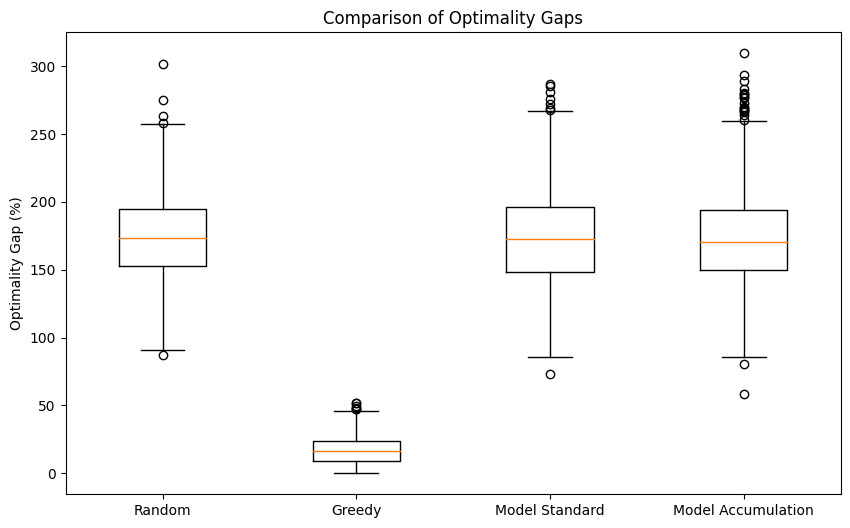

In [112]:
import time
import matplotlib.pyplot as plt

# Inizia a misurare il tempo
start_time = time.time()

# Liste per salvare i gap di ottimalità
gaps_random = []
gaps_greedy = []
gaps_model_standard = []
gaps_model_accumulation = []

# Valutazione sul test set
for batch in testloader:
    # Unpack the batch
    coords_batch, tour_batch = batch  # coords_batch: [batch_size, 20, 2], tour_batch: [batch_size, tour_length]
    
    for coords, tour in zip(coords_batch, tour_batch):
        # Converti il tensor in un grafo NetworkX
        graph = tensor_to_graph(coords, tour.tolist())  # Pass the tour as a list
        
        # Debug: stampa le posizioni dei nodi
        # print("Node positions:", nx.get_node_attributes(graph, 'pos'))
        
        # Calcola i gap per ogni metodo
        gaps = gap(graph, model=model_standard, model_GA=model_accumulation, random_seed=42, device=DEVICE)
        
        # Aggiungi i gap alle liste
        gaps_random.append(gaps['random'])
        gaps_greedy.append(gaps['greedy'])
        gaps_model_standard.append(gaps['transformer_tsp'])
        gaps_model_accumulation.append(gaps['transformer_tsp_acc_grad'])

# Misura il tempo di esecuzione
end_time = time.time()
execution_time = end_time - start_time
print(f"Tempo di esecuzione totale: {execution_time:.2f} secondi")

# Grafico dei risultati
plt.figure(figsize=(10, 6))
plt.boxplot([gaps_random, gaps_greedy, gaps_model_standard, gaps_model_accumulation],
            labels=['Random', 'Greedy', 'Model Standard', 'Model Accumulation'])
plt.ylabel('Optimality Gap (%)')
plt.title('Comparison of Optimality Gaps')
plt.savefig("finalplot.png")
plt.show()
